In [1]:
import os
import logging
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
from scipy.interpolate import interp1d
import scipy.optimize as optimize

try:
    import pycbc
    from pycbc.waveform import utils, get_fd_waveform, get_td_waveform, fd_approximants, td_approximants
    from pycbc.types import TimeSeries, FrequencySeries
except ModuleNotFoundError as err:
    logging.warning('PyCBC package is not installed.'+\
                    'Please install it, as it is required to run TEOBResumS Module and PyCBC waveform class')

from pycbc.types import real_same_precision_as

In [2]:
class Waveform:
    def __init__(self, name, gw_params, data_params):
        self.name = name
        self._set_default_gw_params()
        self.gw_params.update(gw_params)
        self.data_params = data_params
        self._frequency_domain_strain = None
        self._time_domain_strain = None
        self._f_ref = None

        if 'frequencyvector' in data_params:
            self.frequencyvector = data_params['frequencyvector']
        else:
            self.frequencyvector = None

        if 'delta_t' in data_params:
            self.delta_t = data_params['delta_t']
        else:
            if 'eccentricity' in gw_params:
                if ((gw_params['mass_1']+gw_params['mass_2'] > 28) and
                     (gw_params['eccentricity'])<0.3): 
                    # because f_RD_BBH(m_tot=28, q=1, chi1=0.99, chi2=0.99) ~ 960 Hz, 
                    # which is close to the Nyquist frequency of 1024 Hz. 
                    # For higher eccentricities, signal length reduces dramatically.
                    self.delta_t = 0.25/self.f_max
                else:
                    # Set sampling frequency to Nyquist frequency
                    self.delta_t = 0.5/self.f_max
            else:
                self.delta_t = 0.5/self.f_max
        
        if 'min_frequency_cutoff' in gw_params:
            self.min_frequency_cutoff = gw_params['min_frequency_cutoff']
        else:
            self.min_frequency_cutoff = None
        
        if 'max_frequency_cutoff' in gw_params:
            self.max_frequency_cutoff = gw_params['max_frequency_cutoff']
        else:
            self.max_frequency_cutoff = None

    def __call__(self):
        """ Return frequency-domain polarization modes or a time-domain strain."""
        # if 'eccentricity' in self.gw_params:
        #     return self.time_domain_strain
        # else:
        #     return self.frequency_domain_strain
        return self.frequency_domain_strain

    def calculate_frequency_domain_strain(self):
        raise NotImplementedError('Frequency-domain strain is not'+\
                                  'implemented in this class')

    @property
    def frequency_domain_strain(self):
        if self._frequency_domain_strain is None:
            self.calculate_frequency_domain_strain()
            
        if self.max_frequency_cutoff is not None:
            for i in range(2):
                self._frequency_domain_strain[:, i] = np.where(
                    self.frequencyvector <= self.max_frequency_cutoff, 
                    self._frequency_domain_strain[:, i], 
                    0j
                )
        
        if self.min_frequency_cutoff is not None:
            for i in range(2):
                self._frequency_domain_strain[:, i] = np.where(
                    self.frequencyvector >= self.min_frequency_cutoff, 
                    self._frequency_domain_strain[:, i], 
                    0j
                )
        return self._frequency_domain_strain

    def calculate_time_domain_strain(self):
        raise NotImplementedError('Time-domain strain is not implemeted'+\
                                  'in this class')

    @property
    def time_domain_strain(self):
        if self._time_domain_strain is None:
            self.calculate_time_domain_strain()
        return self._time_domain_strain

    @property
    def time_domain_strain(self):
        if self._time_domain_strain is None:
            self.calculate_time_domain_strain()
        # if 'eccentricity' in self.gw_params:
        #     return self._time_domain_strain
        # else:
        return self._frequency_domain_strain

    def _set_default_gw_params(self):
        self.gw_params = {
            'mass_1': 0., 'mass_2': 0., 'luminosity_distance': 0., 
            'redshift': 0., 'theta_jn': 0., 'phase': 0., 'geocent_time': 0., 
            'a_1': 0., 'tilt_1': 0., 'phi_12': 0., 'a_2': 0., 'tilt_2': 0., 
            'phi_jl': 0., 'lambda_1': 0., 'lambda_2': 0.
        }

    def update_gw_params(self, new_gw_params):
        self.gw_params.update(new_gw_params)
        self._frequency_domain_strain = None
        self._time_domain_strain = None

    @property
    def frequencyvector(self):
        return self._frequencyvector

    @frequencyvector.setter
    def frequencyvector(self, new_frequencyvector):
        self._frequencyvector = np.squeeze(new_frequencyvector)

    @property
    def delta_t(self):
        return self._delta_t

    @delta_t.setter
    def delta_t(self, new_delta_t):
        self._delta_t = new_delta_t

    @property
    def f_ref(self):
        """
        Setting reference frequency to minimum frequency if not specified
        """
        if self._f_ref is None:
            if 'f_ref' in self.data_params:
                self._f_ref = self.data_params['f_ref']
            else:
                self._f_ref = self.frequencyvector[0]
        return self._f_ref

    @property
    def f_min(self):
        return self._frequencyvector[0]

    @property
    def f_max(self):
        return self._frequencyvector[-1]

    @property
    def f_nyquist(self):
        return self.f_max

    @property
    def t_obs(self):
        return 1/self.delta_f

    @property
    def delta_f(self):
        return self._frequencyvector[1] - self._frequencyvector[0]

    @property
    def t_of_f(self):
        return t_of_f_PN(self.gw_params, self.frequencyvector)


## Without interpolation

In [3]:
class PyCBC_Waveform_test(Waveform):
    """
    Implementation of PyCBC frequency domain waveform to GWFish.

    Ref - https://github.com/gwastro/pycbc for more details
    """

    def __init__(self, name, gw_params, data_params):
        super().__init__(name, gw_params, data_params)
        self.ht_plus_out = None
        self.ht_cross_out = None
        
        if self.name not in fd_approximants():
            logging.warning(self.name + 'waveform approximant is not implemented in PyCBC')

    def wf_params(self):
        wf_pars = dict(
            approximant = self.name,
            mass1 = self.gw_params['mass_1'],
            mass2 = self.gw_params['mass_2'],
            
            delta_f = self.delta_f,
            delta_t = self.delta_t,
            f_ref = self.f_ref
        )
        
        # spin_input_pars = dict()
        
        # if 'a_1' in self.gw_params: spin_input_pars['a_1'] = self.gw_params['a_1']
        # if 'a_2' in self.gw_params: spin_input_pars['a_2'] = self.gw_params['a_2']


        
        if 'spin1x' in self.gw_params: wf_pars['spin1x'] = self.gw_params['spin1x']
        if 'spin1y' in self.gw_params: wf_pars['spin1y'] = self.gw_params['spin1y']
        if 'spin1z' in self.gw_params: wf_pars['spin1z'] = self.gw_params['spin1z']
        if 'spin2x' in self.gw_params: wf_pars['spin2x'] = self.gw_params['spin2x']
        if 'spin2y' in self.gw_params: wf_pars['spin2y'] = self.gw_params['spin2y']
        if 'spin2z' in self.gw_params: wf_pars['spin2z'] = self.gw_params['spin2z']
        
        if 'eccentricity' in self.gw_params: wf_pars['eccentricity'] = self.gw_params['eccentricity']
            
        if 'lambda1' in self.gw_params: wf_pars['lambda1'] = self.gw_params['lambda1']
        if 'lambda2' in self.gw_params: wf_pars['lambda2'] = self.gw_params['lambda2']

        if 'dquad_mon1' in self.gw_params: wf_pars['dquad_mon1'] = self.gw_params['dquad_mon1']
        if 'dquad_mon2' in self.gw_params: wf_pars['dquad_mon2'] = self.gw_params['dquad_mon2']
        if 'lambda_octu1' in self.gw_params: wf_pars['lambda_octu1'] = self.gw_params['lambda_octu1']
        if 'lambda_octu2' in self.gw_params: wf_pars['lambda_octu2'] = self.gw_params['lambda_octu2']
        if 'quadfmode1'	in self.gw_params: wf_pars['quadfmode1'] = self.gw_params['quadfmode1']
        if 'quadfmode2' in self.gw_params: wf_pars['quadfmode2'] = self.gw_params['quadfmode2']			
        if 'octufmode1' in self.gw_params: wf_pars['octufmode1'] = self.gw_params['octufmode1']	
        if 'octufmode2' in self.gw_params: wf_pars['octufmode2'] = self.gw_params['octufmode2']
            
        if 'dchi0' in self.gw_params: wf_pars['dchi0'] = self.gw_params['dchi0'] 
        if 'dchi1' in self.gw_params: wf_pars['dchi1'] = self.gw_params['dchi1']
        if 'dchi2' in self.gw_params: wf_pars['dchi2'] = self.gw_params['dchi2'] 
        if 'dchi3' in self.gw_params: wf_pars['dchi3'] = self.gw_params['dchi3'] 
        if 'dchi4' in self.gw_params: wf_pars['dchi4'] = self.gw_params['dchi4'] 
        if 'dchi5' in self.gw_params: wf_pars['dchi5'] = self.gw_params['dchi5']
        if 'dchi5l' in self.gw_params: wf_pars['dchi5l'] = self.gw_params['dchi5l'] 
        if 'dchi6' in self.gw_params: wf_pars['dchi6'] = self.gw_params['dchi6'] 
        if 'dchi6l' in self.gw_params: wf_pars['dchi6l'] = self.gw_params['dchi6l'] 			
        if 'dchi7' in self.gw_params: wf_pars['dchi7'] = self.gw_params['dchi7']

        if 'dalpha1' in self.gw_params: wf_pars['dalpha1'] = self.gw_params['dalpha1']
        if 'dalpha2' in self.gw_params: wf_pars['dalpha2'] = self.gw_params['dalpha2']
        if 'dalpha3' in self.gw_params: wf_pars['dalpha3'] = self.gw_params['dalpha3']
        if 'dalpha4' in self.gw_params: wf_pars['dalpha4'] = self.gw_params['dalpha4']
        if 'dalpha5' in self.gw_params: wf_pars['dalpha5'] = self.gw_params['dalpha5']
        if 'dbeta1' in self.gw_params: wf_pars['dbeta1'] = self.gw_params['dbeta1']
        if 'dbeta2' in self.gw_params: wf_pars['dbeta2'] = self.gw_params['dbeta2']
        if 'dbeta3' in self.gw_params: wf_pars['dbeta3'] = self.gw_params['dbeta3'] 
            
        if 'distance' in self.gw_params: wf_pars['distance'] = self.gw_params['distance'] 
        if 'coa_phase' in self.gw_params: wf_pars['coa_phase'] = self.gw_params['coa_phase'] 
        if 'inclination' in self.gw_params: wf_pars['inclination'] = self.gw_params['inclination'] 

        if 'long_asc_nodes' in self.gw_params: wf_pars['long_asc_nodes'] = self.gw_params['long_asc_nodes'] 
        if 'mean_per_ano' in self.gw_params: wf_pars['mean_per_ano'] = self.gw_params['mean_per_ano'] 
        if 'phase_order' in self.gw_params: wf_pars['phase_order'] = self.gw_params['phase_order']
        if 'spin_order' in self.gw_params: wf_pars['spin_order'] = self.gw_params['spin_order'] 
        if 'tidal_order' in self.gw_params: wf_pars['tidal_order'] = self.gw_params['tidal_order'] 
        if 'amplitude_order' in self.gw_params: wf_pars['amplitude_order'] = self.gw_params['amplitude_order'] 
        if 'eccentricity_order' in self.gw_params: wf_pars['eccentricity_order'] = self.gw_params['eccentricity_order'] 
        if 'frame_axis' in self.gw_params: wf_pars['frame_axis'] = self.gw_params['frame_axis'] 
        if 'modes_choice' in self.gw_params: wf_pars['modes_choice'] = self.gw_params['modes_choice'] 
        if 'side_bands' in self.gw_params: wf_pars['side_bands'] = self.gw_params['side_bands'] 
        if 'mode_array' in self.gw_params: wf_pars['mode_array'] = self.gw_params['mode_array']	
        if 'numrel_data' in self.gw_params: wf_pars['numrel_data'] = self.gw_params['numrel_data']

        if 'min_frequency_cutoff' in self.gw_params: wf_pars['f_lower'] = self.gw_params['min_frequency_cutoff']
        if 'max_frequency_cutoff' in self.gw_params: wf_pars['f_final'] = self.gw_params['max_frequency_cutoff']
        if 'f_final_func' in self.gw_params: wf_pars['f_final_func'] = self.gw_params['f_final_func']
            
        pars = wf_pars.copy()
        return pars

    def _fd_gwfish_output_format(self, hfp, hfc):

        hfp = hfp[:, np.newaxis]
        hfc = hfc[:, np.newaxis]

        polarizations = np.hstack((hfp, hfc))

        return polarizations
    

    def calculate_frequency_domain_strain(self):
        pars = self.wf_params()
        self._pycbc_hf_plus_out, self._pycbc_hf_cross_out = get_fd_waveform(pars)
        wf_pol = {'hp':self._pycbc_hf_plus_out, 'hc':self._pycbc_hf_cross_out}
        hp = wf_pol['hp'].to_timeseries()
        
        print('without interpolation------------')
        print('length of waveform:', len(wf_pol['hp']), 'length of gwfish freqVec', len(self._frequencyvector))
        print('pycbc freqVec is spaced linearly but gwfish freqVec is spaced according to detector definition '+\
              'which is defined as log scaled spaceing (geometric)')
        print('pycbc wf: low_f:', wf_pol['hp'].sample_frequencies[0], 'high_f', wf_pol['hp'].sample_frequencies[-1])
        print('gwfish freqVec: low_f:', self._frequencyvector[0], 'high_f', self._frequencyvector[-1])


        """ Interpolation of PyCBC frequency series to a given frequency vector """
        # res = dict()
        
        # for key in wf_pol.keys():
        #     strain_array = np.array(wf_pol[key], dtype=np.complex128)
        #     absolute = np.abs(strain_array)
        #     phase = np.array(pycbc.waveform.utils.phase_from_frequencyseries(wf_pol[key]))
            
        #     if_abs = interp1d(wf_pol[key].sample_frequencies[:], absolute[:], kind='linear')
        #     if_phase = interp1d(wf_pol[key].sample_frequencies[:], phase[:], kind='linear')

        #     interpolated_abs = np.concatenate(([0], if_abs(self._frequencyvector[1:])))
        #     interpolated_phase = np.concatenate(([0], if_phase(self._frequencyvector[1:])))

        #     interpolated = interpolated_abs * np.exp(1j * interpolated_phase)

        #     frequency_bounds = (self._frequencyvector >= self._frequencyvector[0]) * (self._frequencyvector <= self._frequencyvector[-1])
        #     interpolated *= frequency_bounds

        #     assert len(interpolated) == len(self._frequencyvector), 'length mismatch between the required frequency array and waveform output'

        #     res[key] = interpolated
            
        polarizations = self._fd_gwfish_output_format(wf_pol['hp'], wf_pol['hc'])
        self._frequency_domain_strain = polarizations
        # plt.loglog(frequencyvector, np.abs(polarizations[:, 0]), linewidth=2, color='blue', label=r'$h_+$')
        fig = plt.figure(figsize=(16, 6))
        ax1, ax2 = fig.add_subplot(121), fig.add_subplot(122)
        ax1.loglog(wf_pol['hp'].sample_frequencies, abs(wf_pol['hp']))
        ax1.set_title('FD PyCBC')
        ax1.set_xlim([self._frequencyvector[0],self._frequencyvector[-1]])
        ax2.plot(hp.sample_times, hp)
        ax2.set_title('TD PyCBC')
        ax2.set_xlim([-8, 0.5])


In [4]:
import pandas as pd
import GWFish.modules as gw
import json

z = np.array([0])

parameters = {
    'mass_1': np.array([31.4957673]), 
    'mass_2': np.array([21.24276395]),
    'eccentricity': np.array([0.1]), 
    'redshift': z,
    'luminosity_distance': np.array([440]),
    'theta_jn': np.array([2.545065595974997]),
    'ra': np.array([3.4461599999999994]), # phi in gwfast
    'dec': np.array([-0.4080839999999999]), # pi/2 - theta
    'psi': np.array([0.]),
    'phase': np.array([0.]),
    'geocent_time': np.array([1187008882.4]),
    'a_1':np.array([0.005136138323169717]), 
    'a_2':np.array([0.003235146993487445]), 
    'lambda_1':np.array([368.17802383555687]), 
    'lambda_2':np.array([586.5487031450857]),
    'min_frequency_cutoff':10}
parameters = pd.DataFrame(parameters)
parameters

,mass_1,mass_2,eccentricity,redshift,luminosity_distance,theta_jn,ra,dec,psi,phase,geocent_time,a_1,a_2,lambda_1,lambda_2,min_frequency_cutoff
0,31.495767,21.242764,0.1,0,440,2.545066,3.44616,-0.408084,0.0,0.0,1.187009e+09,0.005136,0.003235,368.178024,586.548703,10


In [5]:
GWFish_path = '/home/anik/anaconda3/envs/tgr/lib/python3.9/site-packages/GWFish/'
population = 'BBH' # or 'BBH'
detectors = ['LHO']
networks = '[[0]]'

detectors_ids = detectors
networks_ids = json.loads(networks)
ConfigDet = os.path.join(GWFish_path,'detectors.yaml')

threshold_SNR = np.array([0., 8.])
fisher_parameters = ['mass_1']
network = gw.detection.Network(detectors_ids, detection_SNR=threshold_SNR, parameters=parameters,
                               fisher_parameters=fisher_parameters, config=ConfigDet)
data_params = {
    'frequencyvector': network.detectors[0].frequencyvector,
    'f_ref': 10.
}

without interpolation------------
length of waveform: 9001 length of gwfish freqVec 5000
pycbc freqVec is spaced linearly but gwfish freqVec is spaced according to detector definition which is defined as log scaled spaceing (geometric)
pycbc wf: low_f: 0.0 high_f 83.3752233619176
gwfish freqVec: low_f: 10.0 high_f 1024.0


ValueError: operands could not be broadcast together with shapes (5000,) (9001,) () 

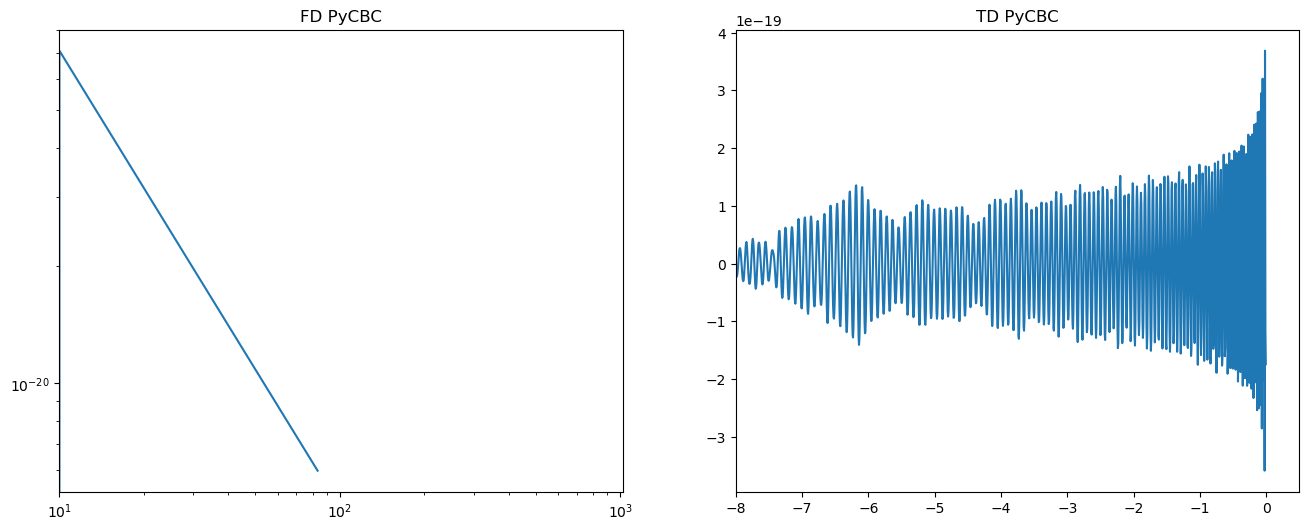

In [6]:
waveform_model = 'TaylorF2Ecc'
waveform_class = PyCBC_Waveform_test
wave_object = waveform_class(waveform_model, parameters.iloc[0], data_params)
wave = wave_object()

## with interpolation

In [7]:
class PyCBC_Waveform_test_inter(Waveform):
    """
    Implementation of PyCBC frequency domain waveform to GWFish.

    Ref - https://github.com/gwastro/pycbc for more details
    """

    def __init__(self, name, gw_params, data_params):
        super().__init__(name, gw_params, data_params)
        self.ht_plus_out = None
        self.ht_cross_out = None
        
        if self.name not in fd_approximants():
            logging.warning(self.name + 'waveform approximant is not implemented in PyCBC')

    def wf_params(self):
        wf_pars = dict(
            approximant = self.name,
            mass1 = self.gw_params['mass_1'],
            mass2 = self.gw_params['mass_2'],
            
            delta_f = self.delta_f,
            delta_t = self.delta_t,
            f_ref = self.f_ref
        )
        
        # spin_input_pars = dict()
        
        # if 'a_1' in self.gw_params: spin_input_pars['a_1'] = self.gw_params['a_1']
        # if 'a_2' in self.gw_params: spin_input_pars['a_2'] = self.gw_params['a_2']


        
        if 'spin1x' in self.gw_params: wf_pars['spin1x'] = self.gw_params['spin1x']
        if 'spin1y' in self.gw_params: wf_pars['spin1y'] = self.gw_params['spin1y']
        if 'spin1z' in self.gw_params: wf_pars['spin1z'] = self.gw_params['spin1z']
        if 'spin2x' in self.gw_params: wf_pars['spin2x'] = self.gw_params['spin2x']
        if 'spin2y' in self.gw_params: wf_pars['spin2y'] = self.gw_params['spin2y']
        if 'spin2z' in self.gw_params: wf_pars['spin2z'] = self.gw_params['spin2z']
        
        if 'eccentricity' in self.gw_params: wf_pars['eccentricity'] = self.gw_params['eccentricity']
            
        if 'lambda1' in self.gw_params: wf_pars['lambda1'] = self.gw_params['lambda1']
        if 'lambda2' in self.gw_params: wf_pars['lambda2'] = self.gw_params['lambda2']

        if 'dquad_mon1' in self.gw_params: wf_pars['dquad_mon1'] = self.gw_params['dquad_mon1']
        if 'dquad_mon2' in self.gw_params: wf_pars['dquad_mon2'] = self.gw_params['dquad_mon2']
        if 'lambda_octu1' in self.gw_params: wf_pars['lambda_octu1'] = self.gw_params['lambda_octu1']
        if 'lambda_octu2' in self.gw_params: wf_pars['lambda_octu2'] = self.gw_params['lambda_octu2']
        if 'quadfmode1'	in self.gw_params: wf_pars['quadfmode1'] = self.gw_params['quadfmode1']
        if 'quadfmode2' in self.gw_params: wf_pars['quadfmode2'] = self.gw_params['quadfmode2']			
        if 'octufmode1' in self.gw_params: wf_pars['octufmode1'] = self.gw_params['octufmode1']	
        if 'octufmode2' in self.gw_params: wf_pars['octufmode2'] = self.gw_params['octufmode2']
            
        if 'dchi0' in self.gw_params: wf_pars['dchi0'] = self.gw_params['dchi0'] 
        if 'dchi1' in self.gw_params: wf_pars['dchi1'] = self.gw_params['dchi1']
        if 'dchi2' in self.gw_params: wf_pars['dchi2'] = self.gw_params['dchi2'] 
        if 'dchi3' in self.gw_params: wf_pars['dchi3'] = self.gw_params['dchi3'] 
        if 'dchi4' in self.gw_params: wf_pars['dchi4'] = self.gw_params['dchi4'] 
        if 'dchi5' in self.gw_params: wf_pars['dchi5'] = self.gw_params['dchi5']
        if 'dchi5l' in self.gw_params: wf_pars['dchi5l'] = self.gw_params['dchi5l'] 
        if 'dchi6' in self.gw_params: wf_pars['dchi6'] = self.gw_params['dchi6'] 
        if 'dchi6l' in self.gw_params: wf_pars['dchi6l'] = self.gw_params['dchi6l'] 			
        if 'dchi7' in self.gw_params: wf_pars['dchi7'] = self.gw_params['dchi7']

        if 'dalpha1' in self.gw_params: wf_pars['dalpha1'] = self.gw_params['dalpha1']
        if 'dalpha2' in self.gw_params: wf_pars['dalpha2'] = self.gw_params['dalpha2']
        if 'dalpha3' in self.gw_params: wf_pars['dalpha3'] = self.gw_params['dalpha3']
        if 'dalpha4' in self.gw_params: wf_pars['dalpha4'] = self.gw_params['dalpha4']
        if 'dalpha5' in self.gw_params: wf_pars['dalpha5'] = self.gw_params['dalpha5']
        if 'dbeta1' in self.gw_params: wf_pars['dbeta1'] = self.gw_params['dbeta1']
        if 'dbeta2' in self.gw_params: wf_pars['dbeta2'] = self.gw_params['dbeta2']
        if 'dbeta3' in self.gw_params: wf_pars['dbeta3'] = self.gw_params['dbeta3'] 
            
        if 'distance' in self.gw_params: wf_pars['distance'] = self.gw_params['distance'] 
        if 'coa_phase' in self.gw_params: wf_pars['coa_phase'] = self.gw_params['coa_phase'] 
        if 'inclination' in self.gw_params: wf_pars['inclination'] = self.gw_params['inclination'] 

        if 'long_asc_nodes' in self.gw_params: wf_pars['long_asc_nodes'] = self.gw_params['long_asc_nodes'] 
        if 'mean_per_ano' in self.gw_params: wf_pars['mean_per_ano'] = self.gw_params['mean_per_ano'] 
        if 'phase_order' in self.gw_params: wf_pars['phase_order'] = self.gw_params['phase_order']
        if 'spin_order' in self.gw_params: wf_pars['spin_order'] = self.gw_params['spin_order'] 
        if 'tidal_order' in self.gw_params: wf_pars['tidal_order'] = self.gw_params['tidal_order'] 
        if 'amplitude_order' in self.gw_params: wf_pars['amplitude_order'] = self.gw_params['amplitude_order'] 
        if 'eccentricity_order' in self.gw_params: wf_pars['eccentricity_order'] = self.gw_params['eccentricity_order'] 
        if 'frame_axis' in self.gw_params: wf_pars['frame_axis'] = self.gw_params['frame_axis'] 
        if 'modes_choice' in self.gw_params: wf_pars['modes_choice'] = self.gw_params['modes_choice'] 
        if 'side_bands' in self.gw_params: wf_pars['side_bands'] = self.gw_params['side_bands'] 
        if 'mode_array' in self.gw_params: wf_pars['mode_array'] = self.gw_params['mode_array']	
        if 'numrel_data' in self.gw_params: wf_pars['numrel_data'] = self.gw_params['numrel_data']

        if 'min_frequency_cutoff' in self.gw_params: wf_pars['f_lower'] = self.gw_params['min_frequency_cutoff']
        if 'max_frequency_cutoff' in self.gw_params: wf_pars['f_final'] = self.gw_params['max_frequency_cutoff']
        if 'f_final_func' in self.gw_params: wf_pars['f_final_func'] = self.gw_params['f_final_func']
            
        pars = wf_pars.copy()
        return pars

    def _fd_gwfish_output_format(self, hfp, hfc):

        hfp = hfp[:, np.newaxis]
        hfc = hfc[:, np.newaxis]

        polarizations = np.hstack((hfp, hfc))

        return polarizations
    

    def calculate_frequency_domain_strain(self):
        pars = self.wf_params()
        self._pycbc_hf_plus_out, self._pycbc_hf_cross_out = get_fd_waveform(pars)
        wf_pol = {'hp':self._pycbc_hf_plus_out, 'hc':self._pycbc_hf_cross_out}
        print('', wf_pol['hp'].sample_frequencies[-1], len(wf_pol['hp']), len(self._frequencyvector))
        """ Interpolation of PyCBC frequency series to a given frequency vector """
        res = dict()

        
        for key in wf_pol.keys():
            strain_array = np.array(wf_pol[key], dtype=np.complex128)
            absolute = np.abs(strain_array)
            phase = np.array(pycbc.waveform.utils.phase_from_frequencyseries(wf_pol[key]))
            
            if_abs = interp1d(wf_pol[key].sample_frequencies[:], absolute[:], kind='linear')
            if_phase = interp1d(wf_pol[key].sample_frequencies[:], phase[:], kind='linear')

            interpolated_abs = np.concatenate(([0], if_abs(self._frequencyvector[1:])))
            interpolated_phase = np.concatenate(([0], if_phase(self._frequencyvector[1:])))

            interpolated = interpolated_abs * np.exp(1j * interpolated_phase)

            frequency_bounds = (self._frequencyvector >= self._frequencyvector[0]) * (self._frequencyvector <= self._frequencyvector[-1])
            interpolated *= frequency_bounds

            assert len(interpolated) == len(self._frequencyvector), 'length mismatch between the required frequency array and waveform output'

            res[key] = interpolated
            
        print('with interpolation------------')
        print('length of waveform:', len(res['hp']), 'length of gwfish freqVec', len(self._frequencyvector))
        print('pycbc freqVec is spaced linearly but gwfish freqVec is spaced according to detector definition '+\
              'which is defined as log scaled spaceing (geometric)')
        print('pycbc wf: low_f:', res['hp'].sample_frequencies[0], 'high_f', res['hp'].sample_frequencies[-1])
        print('gwfish freqVec: low_f:', self._frequencyvector[0], 'high_f', self._frequencyvector[-1])
            
        polarizations = self._fd_gwfish_output_format(res['hp'], res['hc'])
        self._frequency_domain_strain = polarizations
        # plt.loglog(frequencyvector, np.abs(polarizations[:, 0]), linewidth=2, color='blue', label=r'$h_+$')


In [8]:
waveform_model = 'TaylorF2Ecc'
waveform_class_inter = PyCBC_Waveform_test_inter
wave_object_inter = waveform_class_inter(waveform_model, parameters.iloc[0], data_params)
wave_inter = wave_object_inter()

 83.3752233619176 9001 5000


ValueError: A value in x_new is above the interpolation range.

## Fixing

In [49]:
class PyCBC_Waveform(Waveform):
    """
    Implementation of PyCBC frequency domain waveform to GWFish.

    Ref - https://github.com/gwastro/pycbc for more details
    """

    def __init__(self, name, gw_params, data_params):
        super().__init__(name, gw_params, data_params)
        self.ht_plus_out = None
        self.ht_cross_out = None
        
        if self.name not in fd_approximants() and self.name not in td_approximants():
            logging.warning(self.name + 'waveform approximant is not implemented in PyCBC')

    def wf_params(self):
        """ Converting gwfish parameters to waveform parameters """
        pars = dict(
            approximant = self.name,
            mass1 = self.gw_params['mass_1'],
            mass2 = self.gw_params['mass_2'],
            
            delta_f = self.delta_f,
            delta_t = self.delta_t,
            f_ref = self.f_ref
        )
        
        # spin_input_pars = dict()
        
        # if 'a_1' in self.gw_params: spin_input_pars['a_1'] = self.gw_params['a_1']
        # if 'a_2' in self.gw_params: spin_input_pars['a_2'] = self.gw_params['a_2']

        par_keys = ['spin1x', 'spin1y', 'spin1z', 'spin2x', 'spin2y', 'spin2z',
                  'eccentricity', 'lambda1', 'lambda2', 
                  'dquad_mon1', 'dquad_mon2', 'lambda_octu1', 'lambda_octu2', 'quadfmode1', 'quadfmode2', 'octufmode1', 'octufmode2',
                  'dchi0', 'dchi1', 'dchi2', 'dchi3', 'dchi4', 'dchi5', 'dchi5l', 'dchi6', 'dchi6l', 'dchi7',
                  'dalpha1', 'dalpha2', 'dalpha3', 'dalpha4', 'dalpha5', 'dbeta1', 'dbeta2', 'dbeta3',
                  'luminosity_distance', 'coa_phase', 'inclination', 'long_asc_nodes', 'mean_per_ano',
                  'phase_order', 'spin_order', 'tidal_order', 'amplitude_order', 'eccentricity_order', 
                  'frame_axis', 'modes_choice', 'side_bands', 'mode_array''numrel_data', 
                  'min_frequency_cutoff', 'max_frequency_cutoff', 'f_final_func']
        
        for key in par_keys:
            if key in self.gw_params:
                if key == 'luminosity_distance':
                    pars['distance'] = self.gw_params['luminosity_distance']
                elif key == 'min_frequency_cutoff':
                    pars['f_lower'] = self.gw_params['min_frequency_cutoff']
                elif key == 'max_frequency_cutoff':
                    pars['f_final'] = self.gw_params['max_frequency_cutoff']
                else:
                    pars[key] = self.gw_params[key]
            
        pars_ = pars.copy()
        return pars_

    def _fd_gwfish_output_format(self, hfp, hfc):

        hfp = hfp[:, np.newaxis]
        hfc = hfc[:, np.newaxis]

        polarizations = np.hstack((hfp, hfc))

        return polarizations
    

    def calculate_frequency_domain_strain(self):
        pars = self.wf_params()
        
        if self.name in fd_approximants():
            self._pycbc_hf_plus_out, self._pycbc_hf_cross_out = get_fd_waveform(pars)
        elif self.name not in fd_approximants() and self.name in td_approximants():
            self._pycbc_ht_plus_out, self._pycbc_ht_cross_out = get_fd_waveform(pars)
            self._pycbc_hf_plus_out = self._pycbc_ht_plus_out.to_frequencyseries(delta_f=self._pycbc_ht_plus_out.delta_f)
            self._pycbc_hf_cross_out = self._pycbc_ht_cross_out.to_frequencyseries(delta_f=self._pycbc_ht_cross_out.delta_f)

        
        wf_pol = {'hp':self._pycbc_hf_plus_out, 'hc':self._pycbc_hf_cross_out}
        """ Interpolation of PyCBC frequency series to a given frequency vector """
        res = dict()
        
        fig = plt.figure(figsize=(16, 12))
        ax1, ax2, ax3 = fig.add_subplot(221), fig.add_subplot(222), fig.add_subplot(212)
        
        for key in wf_pol.keys():
            strain_array = np.array(wf_pol[key], dtype=np.complex128)
            absolute = np.abs(strain_array)
            phase = np.array(pycbc.waveform.utils.phase_from_frequencyseries(wf_pol[key]))

            if wf_pol[key].sample_frequencies[-1] < self._frequencyvector[-1]:
                freqs = np.concatenate((wf_pol[key].sample_frequencies, [wf_pol[key].sample_frequencies[-1]+wf_pol[key].delta_f, self._frequencyvector[-1]]))
                absolute_ = np.concatenate((absolute, [0, 0]))
                phase_ = np.concatenate((phase, [0, 0]))
            ''' Plotting phase and fd waveform'''
            if key == 'hp':
                print('hp function', abs(phase_[3000]))

                # print(wf_pol['hp'].precision)
                ax1.plot(freqs, phase_, label = 'before interpolation coupled-phase')
                p = np.unwrap(np.angle(wf_pol['hp'].data)).astype(real_same_precision_as(wf_pol['hp']))
                p += -p[0]
                print('hp manual', abs(p[3000]))
                
                ax1.loglog(wf_pol['hp'].sample_frequencies, abs(p), ':', label='actual fuction which extracts phase(uncouples)')
                ax1.set_title('plus pol')
                ax1.set_xlabel('f')
                ax1.set_ylabel('|phase|')

                ax3.loglog(wf_pol['hp'].sample_frequencies, abs(wf_pol['hp']), label='coupled wf without interpolation')
                ax3.set_xlabel('f')
                ax3.set_ylabel('$|~h_{+}^{f}|$')
            else:
                ax2.plot(freqs, phase_, label = 'before interpolation coupled-phase')
                p = np.unwrap(np.angle(wf_pol['hc'].data)).astype(real_same_precision_as(wf_pol['hc']))
                p += -p[0]
                ax2.loglog(wf_pol['hc'].sample_frequencies, abs(p), ':', label='actual fuction which extracts phase(uncouples)')
                ax2.set_title('cross pol')
                ax2.set_xlabel('f')
                
                
            
            if_abs = interp1d(freqs, absolute_, kind='linear')
            if_phase = interp1d(freqs, phase_, kind='linear')

            interpolated_abs = np.concatenate(([0], if_abs(self._frequencyvector[1:])))
            interpolated_phase = np.concatenate(([0], if_phase(self._frequencyvector[1:])))

            interpolated = interpolated_abs * np.exp(1j * interpolated_phase)

            frequency_bounds = (self._frequencyvector >= self._frequencyvector[0]) * (self._frequencyvector <= self._frequencyvector[-1])
            interpolated *= frequency_bounds

            assert len(interpolated) == len(self._frequencyvector), 'length mismatch between the required frequency array and waveform output'

            res[key] = interpolated
            
            ''' Plotting phase and fd waveform after interpolation'''
            if key == 'hp':
                p = np.unwrap(np.angle(res['hp'])).astype('double')
                p += -p[0]
                print('hp inter', abs(p[3000]))
                ax1.plot(self._frequencyvector, abs(p), label = 'after interpolation phase')
                ax1.set_xlim([8, 100])
                ax1.set_title('plus pol')
                
                ax3.loglog(self._frequencyvector, res['hp'], '--', label='coupled wf with interpolation')
                ax3.set_xlim([8, 100])

            else:
                p = np.unwrap(np.angle(res['hc'])).astype('double')
                p += -p[0]
                ax2.plot(self._frequencyvector, abs(p), label = 'after interpolation phase')
                ax2.set_xlim([8, 100])
                ax2.set_title('cross pol')
                
            ax1.legend()
            ax2.legend()
            ax3.legend()
            
            
        print('fixed------------')
        print('length of waveform:', len(res['hp']), 'length of gwfish freqVec', len(self._frequencyvector))
        print('pycbc freqVec is spaced linearly but gwfish freqVec is spaced according to detector definition '+\
              'which is defined as log scaled spaceing (geometric)')
        print('gwfish freqVec: low_f:', self._frequencyvector[0], 'high_f', self._frequencyvector[-1])

        print('')
        print('Found Interpolation is not a good method to create the polarizations'+\
              'the phase graph is changing everytime I run it sometimes its matching sometimes its not.')
        polarizations = self._fd_gwfish_output_format(res['hp'], res['hc'])
        self._frequency_domain_strain = polarizations
        
        # plt.loglog(frequencyvector, np.abs(polarizations[:, 0]), linewidth=2, color='blue', label=r'$h_+$')


            

            


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


hp function 191.1689681843384
hp manual 191.1689681843384
hp inter 226.19467105846527
fixed------------
length of waveform: 5000 length of gwfish freqVec 5000
pycbc freqVec is spaced linearly but gwfish freqVec is spaced according to detector definition which is defined as log scaled spaceing (geometric)
gwfish freqVec: low_f: 10.0 high_f 1024.0

Found Interpolation is not a good method to create the polarizationsthe phase graph is changing everytime I run it sometimes its matching sometimes its not.


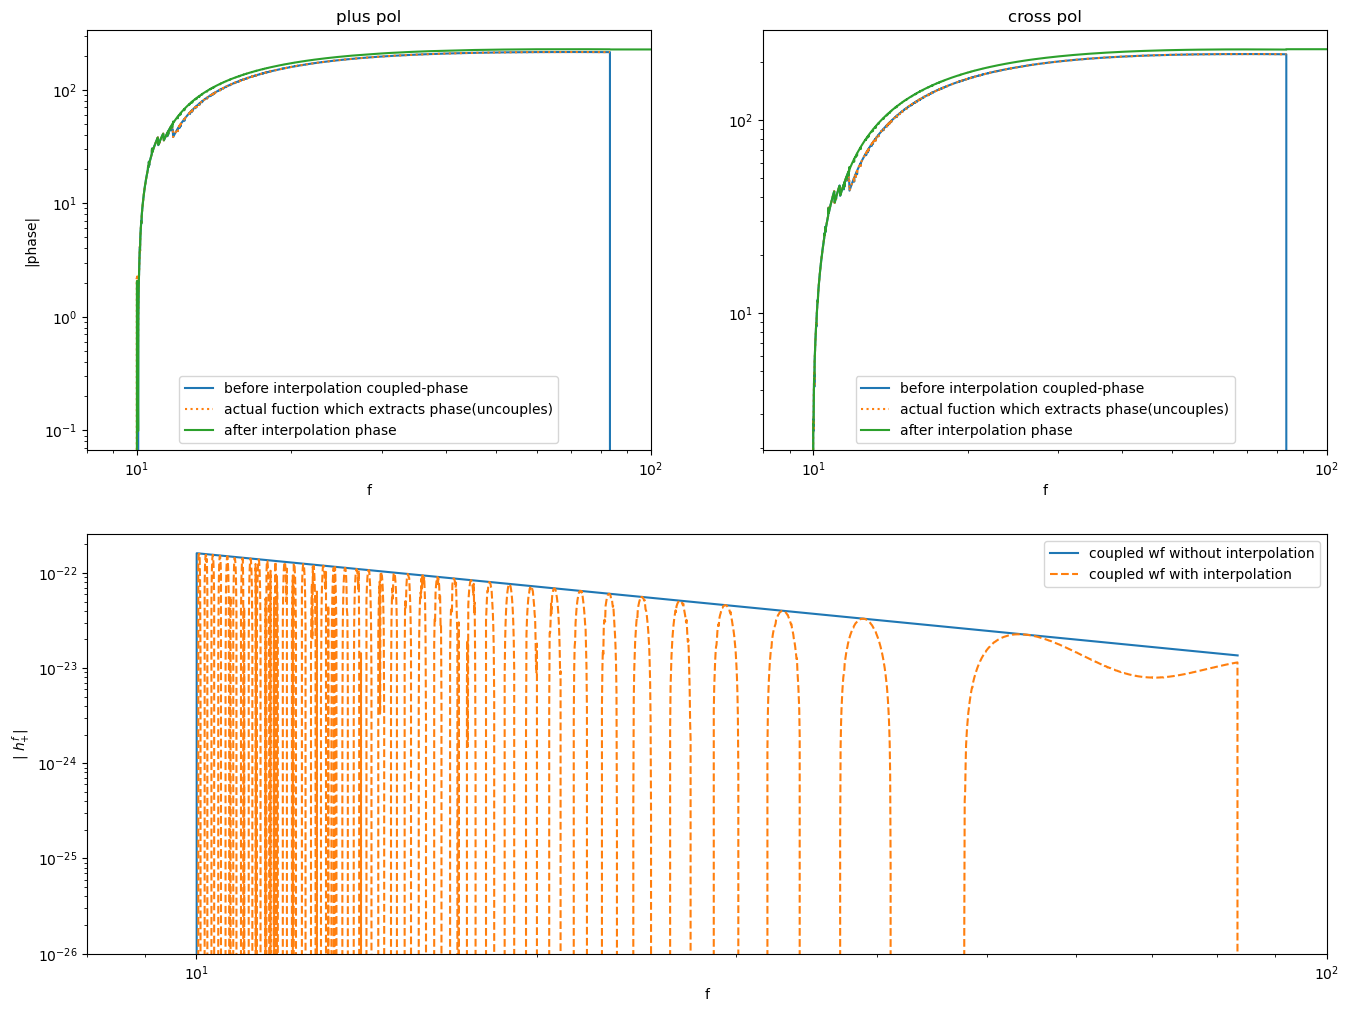

In [50]:
waveform_model = 'TaylorF2Ecc'
waveform_class = PyCBC_Waveform
wave_object_inter = waveform_class(waveform_model, parameters.iloc[0], data_params)
wave_inter = wave_object_inter()